In [1]:
# import vectorbt as vbt
import numpy as np
import pandas as pd
import yfinance as yf
from numba import njit
import ta
from supabase import create_client, Client
from dotenv import load_dotenv
import os
from tqdm import tqdm
load_dotenv()


True

In [6]:
# Pull in data. Calculate PL Dot and Envelope Bot and Top
# daily = pd.read_sql_query('''
#     SELECT * FROM NDX_full_1day
# ''', con = engine.connect())

# Get Supabase credentials from .env
SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

# Create a client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

all_dfs = []
start = 0
chunk_size = 10000

with tqdm(total=None) as pbar:
    while True:
        # Query your database
        data = (supabase
                .table('NDX_full_1day')
                .select("*")
                .order("Datetime", desc=False)
                .range(start, start + chunk_size - 1)  # Adjust the range for each chunk
                .execute())

        # If no data is returned, break the loop
        if not data.data:
            break

        df_data = pd.DataFrame.from_dict(data.data)
        all_dfs.append(df_data)

        # Update the start for the next chunk
        start += chunk_size

        # Update the progress bar
        pbar.update(chunk_size)

daily = pd.concat(all_dfs)
daily['Datetime'] = pd.to_datetime(daily['Datetime'])
# daily['Datetime'] = daily['Datetime'].dt.tz_convert('America/New_York')
daily = daily.set_index('Datetime')
# price = df_price['Close']

20000it [00:00, 27599.14it/s]


In [8]:
# Pull in data. Calculate PL Dot and Envelope Bot and Top
# daily = pd.read_sql_query('''
#     SELECT * FROM NDX_full_1day
# ''', con = engine.connect())

# Get Supabase credentials from .env
SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

# Create a client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

all_dfs = []
start = 0
chunk_size = 10000

with tqdm(total=None) as pbar:
    while True:
        # Query your database
        data = (supabase
                .table('NDX_full_5min')
                .select("*")
                .order("Datetime", desc=False)
                .range(start, start + chunk_size - 1)  # Adjust the range for each chunk
                .execute())

        # If no data is returned, break the loop
        if not data.data:
            break

        df_data = pd.DataFrame.from_dict(data.data)
        all_dfs.append(df_data)

        # Update the start for the next chunk
        start += chunk_size

        # Update the progress bar
        pbar.update(chunk_size)

intra = pd.concat(all_dfs)
intra['Datetime'] = pd.to_datetime(intra['Datetime'])
# intra['Datetime'] = intra['Datetime'].dt.tz_localize('America/New_York')
intra = intra.set_index('Datetime')
# price = df_price['Close']

410000it [00:15, 26456.55it/s]


In [9]:
daily.head()

,Open,High,Low,Close
Datetime,,,,
2000-11-27 00:00:00+00:00,2910.5698,2913.7600,2759.9800,2769.3198
2000-11-27 00:00:00+00:00,2910.5698,2913.7600,2759.9800,2769.3198
2000-11-28 00:00:00+00:00,2763.8601,2795.1499,2619.5000,2621.1101
2000-11-28 00:00:00+00:00,2763.8601,2795.1499,2619.5000,2621.1101
2000-11-29 00:00:00+00:00,2635.0500,2670.5300,2520.1396,2603.2600


In [10]:
intra.head()

,Open,High,Low,Close
Datetime,,,,
2008-01-02 09:30:00+00:00,2085.53,2090.53,2085.53,2090.53
2008-01-02 09:30:00+00:00,2085.53,2090.53,2085.53,2090.53
2008-01-02 09:35:00+00:00,2091.10,2092.54,2088.45,2092.54
2008-01-02 09:35:00+00:00,2091.10,2092.54,2088.45,2092.54
2008-01-02 09:40:00+00:00,2092.92,2094.22,2091.54,2092.07


In [11]:
intra = intra.drop_duplicates()

In [12]:
intra.head()

,Open,High,Low,Close
Datetime,,,,
2008-01-02 09:30:00+00:00,2085.53,2090.53,2085.53,2090.53
2008-01-02 09:35:00+00:00,2091.10,2092.54,2088.45,2092.54
2008-01-02 09:40:00+00:00,2092.92,2094.22,2091.54,2092.07
2008-01-02 09:45:00+00:00,2092.54,2092.62,2090.03,2090.03
2008-01-02 09:50:00+00:00,2089.18,2091.27,2088.81,2091.24


In [13]:
daily = daily.reset_index()
intra = intra.reset_index()

In [17]:
daily['HLC3'] = (daily['High'] + daily['Low'] + daily['Close']) / 3
daily['PLDot'] = daily['HLC3'].rolling(3).mean()
daily['High11'] = (daily['HLC3'] * 2) - daily['Low']
daily['Low11'] = (daily['HLC3'] * 2) - daily['High']
daily['ETop'] = daily['High11'].rolling(3).mean()
daily['EBot'] = daily['Low11'].rolling(3).mean()
daily['SDHighs'] = daily['ETop'].rolling(10).std()
daily['SDLows'] = daily['ETop'].rolling(10).std()
daily['XTop'] = daily['ETop'] + daily['SDHighs']
daily['XTop2'] = daily['XTop'] + daily['SDHighs']
daily['XBot'] = daily['EBot'] - daily['SDLows']
daily['XBot2'] = daily['XBot'] - daily['SDLows']

# daily['High11'] = daily['High11'].shift(1)
# daily['Low11'] = daily['Low11'].shift(1)
daily['PLDot'] = daily['PLDot'].shift(1)
daily['ETop'] = daily['ETop'].shift(1)
daily['EBot'] = daily['EBot'].shift(1)
daily['XTop'] = daily['XTop'].shift(1)
daily['XTop2'] = daily['XTop2'].shift(1)
daily['XBot'] = daily['XBot'].shift(1)
daily['XBot2'] = daily['XBot2'].shift(1)

In [18]:
daily['PrevClose'] = daily['Close'].shift(1)
daily['NextClose'] = daily['Close'].shift(-1)
daily['GreenDay'] = daily['Close'] > daily['PrevClose']
daily['Gap'] = (daily['Open'] / daily['PrevClose']) - 1
daily['Year'] = daily['Datetime'].dt.year
daily['EnvSize'] = daily['ETop'] - daily['EBot']
daily['EnvSizePct'] = daily['EnvSize'] / daily['PrevClose']

# Closes
daily['OpenAbovePLDot'] = daily['Open'] > daily['PLDot']
daily['OpenAboveETop'] = daily['Open'] > daily['ETop']
daily['OpenAboveEBot'] = daily['Open'] > daily['EBot']
daily['OpenAboveXBot'] = daily['Open'] > daily['XBot']
daily['OpenAboveXTop'] = daily['Open'] > daily['XTop']
daily['CloseAboveETop'] = daily['Close'] > daily['ETop']
daily['CloseAboveXTop'] = daily['Close'] > daily['XTop']
daily['CloseAboveXTop2'] = daily['Close'] > daily['XTop2']
daily['CloseBelowEBot'] = daily['Close'] < daily['EBot']
daily['CloseBelowXBot'] = daily['Close'] < daily['XBot']
daily['CloseBelowXBot2'] = daily['Close'] < daily['XBot2']
daily['CloseInEnv'] = (daily['Close'] > daily['EBot']) & (daily['Close'] < daily['ETop'])
daily['CloseInX'] = (daily['Close'] > daily['XBot']) & (daily['Close'] < daily['XTop'])
daily['CloseInX2'] = (daily['Close'] > daily['XBot2']) & (daily['Close'] < daily['XTop2'])
daily['CloseAbovePLDot'] = daily['Close'] > daily['PLDot']



In [19]:
close_cols = [
    'CloseAboveXTop2',
    'CloseAboveXTop',
    'CloseAboveETop',
    'CloseAbovePLDot',
    'CloseBelowEBot',
    'CloseBelowXBot',
    'CloseBelowXBot2',
    'CloseInEnv',
    'CloseInX',
    'CloseInX2',
    'GreenDay'
]

touch_from_above_cols = [
    'TouchXTop2FromAbove',
    'TouchXTopFromAbove',
    'TouchETopFromAbove',
    'TouchPLDotFromAbove',
    'TouchEBotFromAbove',
    'TouchXBotFromAbove',
    'TouchXBot2FromAbove'
]

touch_from_below_cols = [
    'TouchXTop2FromBelow',
    'TouchXTopFromBelow',
    'TouchETopFromBelow',
    'TouchPLDotFromBelow',
    'TouchEBotFromBelow',
    'TouchXBotFromBelow',
    'TouchXBot2FromBelow'
]

In [20]:
import matplotlib.pyplot as plt
def getStats(query):
    """
    Given a condition, determine whether price was able to touch certain levels.
    """
    df_use = daily.query(query)
    # Touch From Below
    df_use.loc[:,'TouchETopFromBelow'] = (df_use['High'] > df_use['ETop']) & (df_use['Open'] < df_use['ETop'])
    df_use.loc[:,'TouchXTopFromBelow'] = (df_use['High'] > df_use['XTop']) & (df_use['Open'] < df_use['XTop'])
    df_use.loc[:,'TouchXTop2FromBelow'] = (df_use['High'] > df_use['XTop2']) & (df_use['Open'] < df_use['XTop2'])
    df_use.loc[:,'TouchPLDotFromBelow'] = (df_use['High'] > df_use['PLDot']) & (df_use['Open'] < df_use['PLDot'])
    df_use.loc[:,'TouchEBotFromBelow'] = (df_use['High'] > df_use['EBot']) & (df_use['Open'] < df_use['EBot'])
    df_use.loc[:,'TouchXBotFromBelow'] = (df_use['High'] > df_use['XBot']) & (df_use['Open'] < df_use['XBot'])
    df_use.loc[:,'TouchXBot2FromBelow'] = (df_use['High'] > df_use['XBot2']) & (df_use['Open'] < df_use['XBot2'])

    # Touch From Above
    df_use.loc[:,'TouchETopFromAbove'] = (df_use['Low'] < df_use['ETop']) & (df_use['Open'] > df_use['ETop'])
    df_use.loc[:,'TouchXTopFromAbove'] = (df_use['Low'] < df_use['XTop']) & (df_use['Open'] > df_use['XTop'])
    df_use.loc[:,'TouchXTop2FromAbove'] = (df_use['Low'] < df_use['XTop2']) & (df_use['Open'] > df_use['XTop2'])
    df_use.loc[:,'TouchPLDotFromAbove'] = (df_use['Low'] < df_use['PLDot']) & (df_use['Open'] > df_use['PLDot'])
    df_use.loc[:,'TouchEBotFromAbove'] = (df_use['Low'] < df_use['EBot']) & (df_use['Open'] > df_use['EBot'])
    df_use.loc[:,'TouchXBotFromAbove'] = (df_use['Low'] < df_use['XBot']) & (df_use['Open'] > df_use['XBot'])
    df_use.loc[:,'TouchXBot2FromAbove'] = (df_use['Low'] < df_use['XBot2']) & (df_use['Open'] > df_use['XBot2'])
    df_above_touch = df_use[touch_from_above_cols].mean()
    df_below_touch = df_use[touch_from_below_cols].mean()
    df_close = df_use[close_cols].mean()
    plt.figure(figsize=(8, 5))
    plt.suptitle(f'Stats for when {query}\n(n={len(df_use):,.0f}/{len(daily):,.0f})')
    plt.subplot(1, 3, 1)
    df_above_touch.loc[df_above_touch > 0].plot(kind='bar', title=f'Touch from Above')
    for i, v in enumerate(df_above_touch.loc[df_above_touch > 0]):
        plt.text(i, v + 0.01, f'{v:.0%}', ha='center', va='bottom', fontsize=8)
    plt.subplot(1, 3, 2)
    df_below_touch.loc[df_below_touch > 0].plot(kind='bar', title=f'Touch from Below')
    for i, v in enumerate(df_below_touch.loc[df_below_touch > 0]):
        plt.text(i, v + 0.01, f'{v:.0%}', ha='center', va='bottom', fontsize=8)
    plt.subplot(1, 3, 3)
    df_close.loc[df_close > 0].plot(kind='bar', title=f'Close Stats')
    for i, v in enumerate(df_close.loc[df_close > 0]):
        plt.text(i, v + 0.01, f'{v:.0%}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_28464\2452504738.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use.loc[:,'TouchETopFromBelow'] = (df_use['High'] > df_use['ETop']) & (df_use['Open'] < df_use['ETop'])
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_28464\2452504738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use.loc[:,'TouchXTopFromBelow'] = (df_use['High'] > df_use['XTop']) & (df_use['Open'] < df_use['XTop'])
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_28464\2452

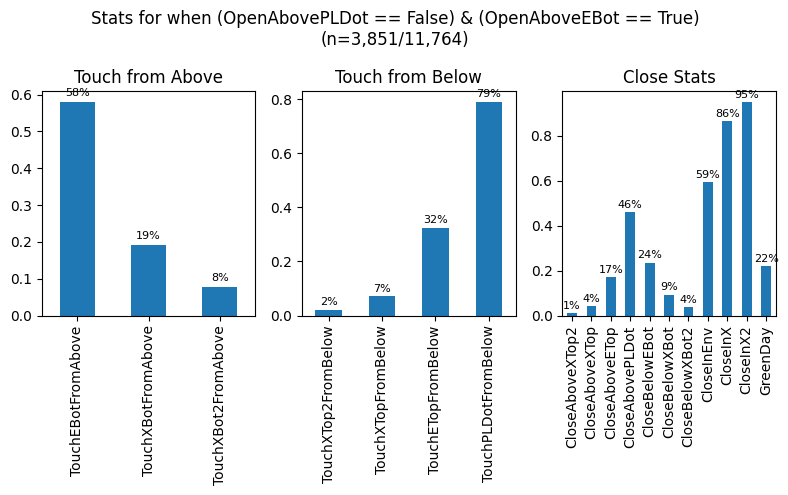

In [21]:
getStats('(OpenAbovePLDot == False) & (OpenAboveEBot == True)')

# Exhaust Analysis

In [22]:
# Given a 5 min high > Daily XTop, Show performance of the next 12 bars relative to that high.
daily.dtypes

Datetime           datetime64[ns, UTC]
Open                           float64
High                           float64
Low                            float64
Close                          float64
HLC3                           float64
PLDot                          float64
High11                         float64
Low11                          float64
ETop                           float64
EBot                           float64
SDHighs                        float64
SDLows                         float64
XTop                           float64
XTop2                          float64
XBot                           float64
XBot2                          float64
PrevClose                      float64
NextClose                      float64
GreenDay                          bool
Gap                            float64
Year                             int32
EnvSize                        float64
EnvSizePct                     float64
OpenAbovePLDot                    bool
OpenAboveETop            

In [23]:
intra['Date'] = pd.to_datetime(intra['Datetime'].dt.date, utc=True)

In [24]:
intra.dtypes

Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Date        datetime64[ns, UTC]
dtype: object

In [25]:
intra_data = intra.merge(daily[['Datetime','XBot2','XBot','EBot','PLDot','ETop','XTop','XTop2']], how = 'left', left_on = 'Date', right_on = 'Datetime')

In [26]:
intra_data.head()

,Datetime_x,Open,High,Low,Close,Date,Datetime_y,XBot2,XBot,EBot,PLDot,ETop,XTop,XTop2
0,2008-01-02 09:30:00+00:00,2085.53,2090.53,2085.53,2090.53,2008-01-02 00:00:00+00:00,2008-01-02 00:00:00+00:00,2058.753465,2070.828954,2082.904444,2095.795556,2105.194444,2117.269934,2129.345424
1,2008-01-02 09:30:00+00:00,2085.53,2090.53,2085.53,2090.53,2008-01-02 00:00:00+00:00,2008-01-02 00:00:00+00:00,2028.712532,2045.207377,2061.702222,2080.684444,2092.172222,2108.667067,2125.161913
2,2008-01-02 09:35:00+00:00,2091.10,2092.54,2088.45,2092.54,2008-01-02 00:00:00+00:00,2008-01-02 00:00:00+00:00,2058.753465,2070.828954,2082.904444,2095.795556,2105.194444,2117.269934,2129.345424
3,2008-01-02 09:35:00+00:00,2091.10,2092.54,2088.45,2092.54,2008-01-02 00:00:00+00:00,2008-01-02 00:00:00+00:00,2028.712532,2045.207377,2061.702222,2080.684444,2092.172222,2108.667067,2125.161913
4,2008-01-02 09:40:00+00:00,2092.92,2094.22,2091.54,2092.07,2008-01-02 00:00:00+00:00,2008-01-02 00:00:00+00:00,2058.753465,2070.828954,2082.904444,2095.795556,2105.194444,2117.269934,2129.345424


In [27]:
# Mark Highs > XTop2
intra_data['ExhaustXTop2'] = intra_data['High'] > intra_data['XTop2']
intra_data['ExhaustXTop'] = intra_data['High'] > intra_data['XTop']

In [28]:
from tqdm import tqdm
xtop2_rows = []
for i in tqdm(range(len(intra_data))):
    if intra_data.loc[i, 'ExhaustXTop2']:
        xtop2_rows.append(intra_data.iloc[i:i+13])

100%|██████████| 645768/645768 [00:03<00:00, 181026.94it/s]


In [29]:
dates, x2s, x2breaches, highs, lows, closes = [], [], [], [], [], []
for df in tqdm(xtop2_rows):
    # Clean DFs such that only rows with len == 12 and all rows are from the same session as the breach. are included in analysis
    df_clean = df.loc[df['Date'] == df['Date'].iloc[0]]
    # Calculate the highest high, lowest low, and close of the last bar
    if len(df_clean) == 12:
        dates.append(df_clean['Datetime_x'].iloc[0])
        x2s.append(df_clean['XTop2'].iloc[0])
        x2breaches.append(df_clean['High'].iloc[0])
        highs.append(df_clean['High'].iloc[1:].max())
        lows.append(df_clean['Low'].iloc[1:].min())
        closes.append(df_clean['Close'].iloc[-1])
    else:
        continue

100%|██████████| 17392/17392 [00:06<00:00, 2843.42it/s]


In [30]:
df_compare = pd.DataFrame(data={
    'dates':dates,
    'x2':x2s,
    'x2breach':x2breaches,
    'hh':highs,
    'll':lows,
    'cc':closes
})

In [31]:
df_compare['MAE_pts'] = (df_compare['hh'] - df_compare['x2breach'])
df_compare['MFE_pts'] = (df_compare['ll'] - df_compare['x2breach'])
df_compare['FinalClose_pts'] = (df_compare['cc'] - df_compare['x2breach'])

df_compare['MAE_pct'] = df_compare['MAE_pts'] / df_compare['x2breach']
df_compare['MFE_pct'] = df_compare['MFE_pts'] / df_compare['x2breach']
df_compare['FinalClose_pct'] = df_compare['FinalClose_pts'] / df_compare['x2breach']

df_compare['rr'] = df_compare['MFE_pts'].abs() / df_compare['MAE_pts'].abs()

In [32]:
df_compare_single = df_compare.groupby(df_compare['dates'].dt.date).head(1)

In [33]:
df_compare_single['rr'].describe()

d:\Projects\breeze_bt\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    246.000000
mean            inf
std             NaN
min        0.058985
25%        0.732311
50%        2.062193
75%       15.675403
max             inf
Name: rr, dtype: float64

In [40]:
df_compare_single['rr'].clip(-1,100).describe()

count    246.000000
mean      22.370951
std       38.165109
min        0.058985
25%        0.732311
50%        2.062193
75%       15.675403
max      100.000000
Name: rr, dtype: float64

In [ ]:
df_compare_single['']

In [35]:
len(df_compare_single)

246

In [41]:
df_compare_single['MAE_pct'].mean()

0.0011466981895379078

In [42]:
df_compare_single['MFE_pct'].mean()

-0.0019863283974560484

In [43]:
df_compare_single['FinalClose_pct'].mean()

-6.953687430041254e-05

In [44]:
len(df_compare_single[(df_compare_single['FinalClose_pts'] < 0)]) / len(df_compare_single)

0.5121951219512195